In [1]:
# !unzip '/content/Phase2.zip'

## Imports

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [18]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-2
NUM_CLASSES = 3
CLASSES = ['Gaussian', 'Periodic', 'Salt']
N_CHANNELS = 3

In [4]:
base_dir = './content/DataSet2'

In [5]:
import cv2

# def convert_to_ms(image):
#     image = np.fft.fftshift(np.fft.fft2(image))
#     image = 20*np.log(np.abs(image))
#     return image

def convert_to_ms(image):
    if(N_CHANNELS==3):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.fft.fftshift(np.fft.fft2(image))
    image = 20*(np.log(np.abs(image)))
    image = (image / np.max(image))*255
    image = np.uint8(np.round(image))
    if(N_CHANNELS==3):
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image = image/255
    return image

In [6]:
def read_images(files):
    if os.path.isfile(files):
        if(N_CHANNELS==1):
            return cv2.resize(cv2.imread(files, cv2.IMREAD_GRAYSCALE), dsize=(IMAGE_HEIGHT,IMAGE_WIDTH))
        else:
            return cv2.resize(cv2.imread(files), dsize=(IMAGE_HEIGHT,IMAGE_WIDTH))
    arr = []
    for file in files:
        if(N_CHANNELS==1):
            arr.append(cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE), dsize=(IMAGE_HEIGHT,IMAGE_WIDTH)))
        else:
            arr.append(cv2.resize(cv2.imread(file), dsize=(IMAGE_HEIGHT,IMAGE_WIDTH)))
    return np.array(arr)

In [7]:
data = pd.read_excel('./content/Labels.xlsx')
data.head()

,Denoise Image,Noise Type,Noisy Image
0,Without-Noise/cast_def_0_0.jpeg,Gaussian,With-Noise/cast_def_0_0.jpeg
1,Without-Noise/cast_def_0_2.jpeg,Gaussian,With-Noise/cast_def_0_2.jpeg
2,Without-Noise/cast_def_0_22.jpeg,Gaussian,With-Noise/cast_def_0_22.jpeg
3,Without-Noise/cast_def_0_25.jpeg,Gaussian,With-Noise/cast_def_0_25.jpeg
4,Without-Noise/cast_def_0_33.jpeg,Gaussian,With-Noise/cast_def_0_33.jpeg


In [8]:
all_data = {'data': np.array([convert_to_ms(read_images(os.path.join(base_dir,file))) for file in data['Noisy Image']]),
              'labels': np.array([0 if t==CLASSES[0] else 1 if t==CLASSES[1] else 2 for t in data['Noise Type']]),
              'names': np.array([name for name in data['Noisy Image']])}
print('data:', all_data['data'].shape, 'type', type(all_data['data'][0,0,0,0]))
print('labels:', all_data['labels'].shape, 'type', type(all_data['labels'][0]))

data: (1250, 224, 224, 3) type <class 'numpy.float64'>
labels: (1250,) type <class 'numpy.int32'>


With-Noise/cast_def_0_0.jpeg


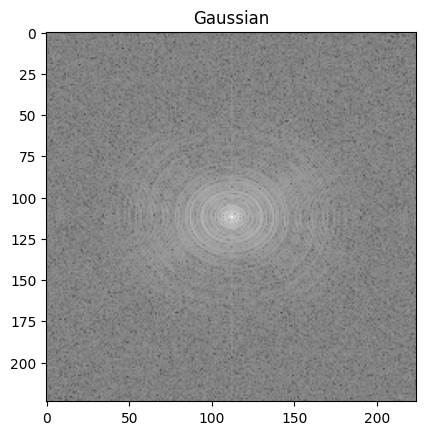

In [9]:
print(all_data['names'][0])
plt.title(CLASSES[all_data['labels'][0]])
plt.imshow(all_data['data'][0])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_data['data'], all_data['labels'], test_size=0.2, random_state=100)

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks for early stopping, model checkpointing, and learning rate reduction
my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
]

## VGG16

In [12]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.layers import Flatten, Dense, MaxPooling2D, Dropout, Conv2D
from keras.models import Model
from keras.losses import CategoricalCrossentropy



# Load pre-trained VGG16 model without the top layers
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze pre-trained layers for fine-tuning later
for layer in pretrained_model.layers:
    layer.trainable = False

x = pretrained_model.output
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create full model
VGG16_model = Model(inputs=pretrained_model.input, outputs=predictions)

VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
VGG16_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [14]:
from keras.utils import to_categorical

history = 0
with tf.device('/GPU:0'):
    history = VGG16_model.fit(
        x = np.array(X_train),
        y = np.array(to_categorical(y_train)),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(np.array(X_test), np.array(to_categorical(y_test))),
        # validation_steps=5,
        callbacks=my_callbacks
    )

Epoch 1/25
32/32 [==============================] - 30s 664ms/step - loss: 1.3917 - accuracy: 0.7080 - val_loss: 0.1651 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 2/25
32/32 [==============================] - 11s 350ms/step - loss: 0.2205 - accuracy: 0.9250 - val_loss: 0.1393 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 3/25
32/32 [==============================] - 11s 354ms/step - loss: 0.1764 - accuracy: 0.9400 - val_loss: 0.1108 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 4/25
32/32 [==============================] - 11s 353ms/step - loss: 0.2022 - accuracy: 0.9350 - val_loss: 0.1271 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 5/25
32/32 [==============================] - 10s 300ms/step - loss: 0.1291 - accuracy: 0.9560 - val_loss: 0.3007 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 6/25
32/32 [==============================] - 11s 357ms/step - loss: 0.1283 - accuracy: 0.9480 - val_loss: 0.0891 - val_accuracy: 0.9640 - lr: 1.0000e-04
Epoch 7/25
32/32 [==============================] - 11s 354m

In [15]:
predict = np.argmax(VGG16_model.predict(np.array(X_test)), axis=1)

8/8 [==============================] - 2s 236ms/step


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        76
           1       1.00      1.00      1.00        92
           2       0.93      1.00      0.96        82

    accuracy                           0.98       250
   macro avg       0.98      0.97      0.97       250
weighted avg       0.98      0.98      0.98       250



In [17]:
print("[INFO] Calculating model accuracy")
scores = VGG16_model.evaluate(np.array(X_test), np.array(to_categorical(y_test)))
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 235ms/step - loss: 0.0819 - accuracy: 0.9760
Test Accuracy: 97.60000109672546


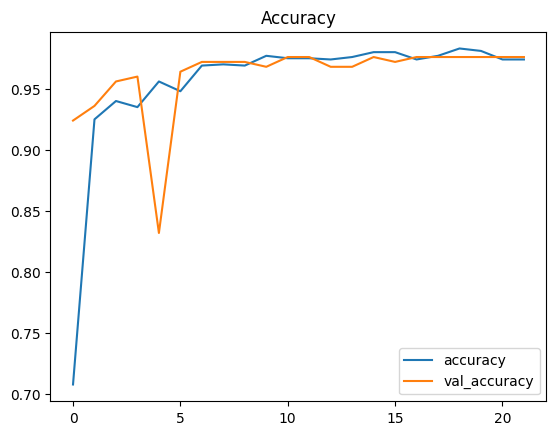

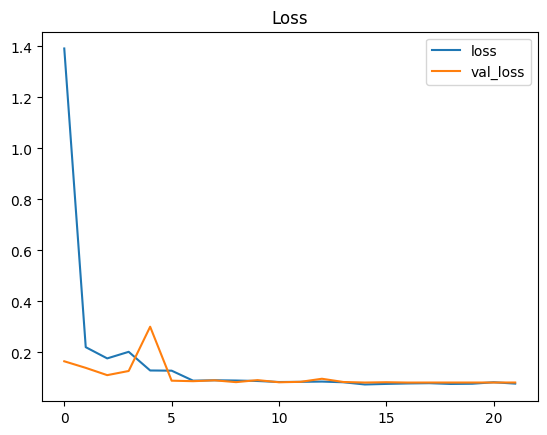

In [19]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [19]:
VGG16_model.save('./content/models/VGG16_Freq_Classification2.h5')

## Inception ResNet V2

In [20]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

pretrained_model = InceptionResNetV2(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [21]:
from keras.layers import Dense
from keras import Model

x = pretrained_model.output
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


model = Model(inputs=pretrained_model.input, outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

 batch_normalization_1 (BatchNo  (None, 109, 109, 32  96         ['conv2d_1[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_1 (Activation)      (None, 109, 109, 32  0           ['batch_normalization_1[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 109, 109, 64  18432       ['activation_1[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 109, 109, 64  192        ['conv2d_2[0][0]']               
 rmalizati

In [22]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [23]:
history = 0
with tf.device('/GPU:0'):
    history = model.fit(
        x = np.array(X_train),
        y = np.array(to_categorical(y_train)),
        steps_per_epoch=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(np.array(X_test), np.array(to_categorical(y_test))),
        # validation_steps=5,
        callbacks=my_callbacks
    )

Epoch 1/25
32/32 [==============================] - 26s 524ms/step - loss: 0.9467 - accuracy: 0.7540 - val_loss: 0.1940 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 2/25
32/32 [==============================] - 11s 344ms/step - loss: 0.1511 - accuracy: 0.9440 - val_loss: 0.1676 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 3/25
32/32 [==============================] - 11s 344ms/step - loss: 0.1494 - accuracy: 0.9380 - val_loss: 0.1117 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 4/25
32/32 [==============================] - 11s 344ms/step - loss: 0.1539 - accuracy: 0.9480 - val_loss: 0.1132 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 5/25
32/32 [==============================] - 11s 344ms/step - loss: 0.1759 - accuracy: 0.9330 - val_loss: 0.1108 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 6/25
32/32 [==============================] - 11s 344ms/step - loss: 0.1252 - accuracy: 0.9560 - val_loss: 0.1008 - val_accuracy: 0.9640 - lr: 0.0010
Epoch 7/25
32/32 [==============================] - 11s 344ms/st

In [24]:
predict = np.int8(np.argmax(model.predict(np.array(X_test)), axis=1))

8/8 [==============================] - 5s 281ms/step


In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94        76
           1       0.99      1.00      0.99        92
           2       0.92      0.99      0.95        82

    accuracy                           0.96       250
   macro avg       0.97      0.96      0.96       250
weighted avg       0.97      0.96      0.96       250



In [26]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(np.array(X_test), np.array(to_categorical(y_test)))
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 271ms/step - loss: 0.0912 - accuracy: 0.9640
Test Accuracy: 96.39999866485596


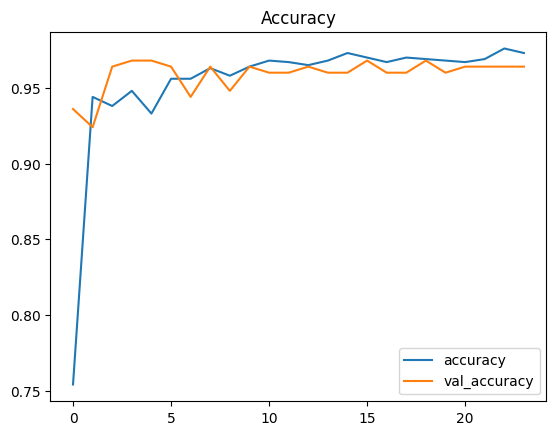

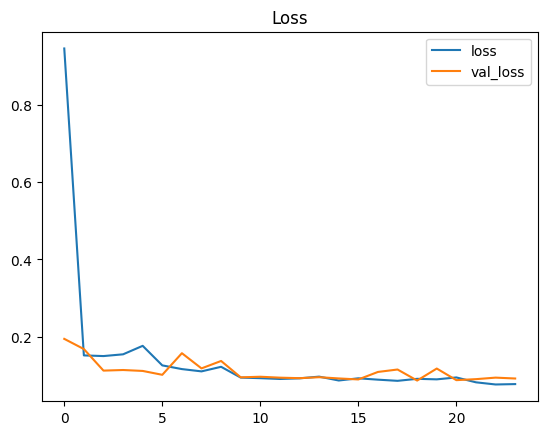

In [27]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [28]:
model.save('./content/models/InceptionResNetV2_Freq_Classification.h5')

1/1 [==============================] - 4s 4s/step
Gaussian


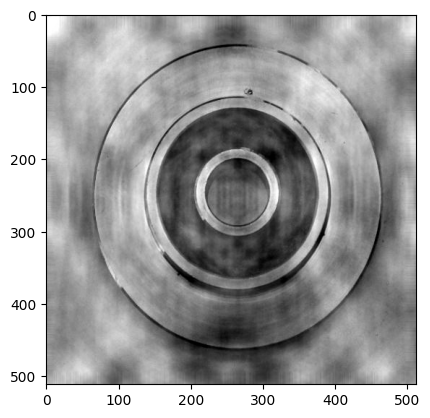

In [29]:
import keras.utils as image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='./content/DataSet2/Classification/Train/With-Noise/Periodic/cast_def_0_3185.jpeg'
result = model.predict([prepare(img_url)])
casting_img=image.load_img(img_url)
plt.imshow(casting_img)

classresult=np.argmax(result,axis=1)
print(CLASSES[classresult[0]])

array([0.04313725, 0.05490196, 0.07843137, 0.09411765, 0.10196078,
       0.10588235, 0.10980392, 0.11372549, 0.11764706, 0.12156863,
       0.1254902 , 0.12941176, 0.13333333, 0.1372549 , 0.14117647,
       0.14509804, 0.14901961, 0.15294118, 0.15686275, 0.16078431,
       0.16470588, 0.16862745, 0.17254902, 0.17647059, 0.18039216,
       0.18431373, 0.18823529, 0.19215686, 0.19607843, 0.2       ,
       0.20392157, 0.20784314, 0.21176471, 0.21568627, 0.21960784,
       0.22352941, 0.22745098, 0.23137255, 0.23529412, 0.23921569,
       0.24313725, 0.24705882, 0.25098039, 0.25490196, 0.25882353,
       0.2627451 , 0.26666667, 0.27058824, 0.2745098 , 0.27843137,
       0.28235294, 0.28627451, 0.29019608, 0.29411765, 0.29803922,
       0.30196078, 0.30588235, 0.30980392, 0.31372549, 0.31764706,
       0.32156863, 0.3254902 , 0.32941176, 0.33333333, 0.3372549 ,
       0.34117647, 0.34509804, 0.34901961, 0.35294118, 0.35686275,
       0.36078431, 0.36470588, 0.36862745, 0.37254902, 0.37647

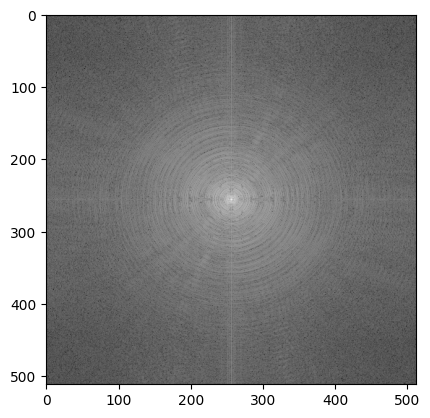

In [30]:
def convert_to_ms(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.fft.fftshift(np.fft.fft2(image))
    image = 20*np.log(np.abs(image))
    image = (image / np.max(image))*255
    image = cv2.cvtColor(np.uint8(np.round(image)), cv2.COLOR_GRAY2BGR)
    return image


img = cv2.imread('./content/DataSet2/Classification/Train/With-Noise/Periodic/cast_def_0_3185.jpeg')
plt.imshow(convert_to_ms(img))
np.unique(convert_to_ms(img)/255)